In [ ]:
!pip install agentpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
import agentpy as ap
import numpy as np
import socket
import json
import time
import random, json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import IPython
from matplotlib import pyplot as plt, cm
import copy
from collections import defaultdict

# Valores para representación visual
e, r, g, w, explorer, goal, car,n,s,z,x,p,o = 100, 10, 3, 2, -1, -2, -3,11,12,13,14,98,99


def transform_maze(maze,e,r,g,w,n,s,z,x):
    # Create an empty integer matrix with the same shape as the input maze
    int_maze = np.zeros_like(maze, dtype=int)

    # Step 1: Replace characters with respective integer values, except for 'e'
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == r:
                int_maze[i, j] = 2
            elif maze[i, j] == w:
                int_maze[i, j] = 1
            elif maze[i, j] == g:
                int_maze[i, j] = 5
            elif maze[i, j] == n:
                int_maze[i, j] = 2
            elif maze[i, j] == s:
                int_maze[i, j] = 2
            elif maze[i, j] == z:
                int_maze[i, j] = 2
            elif maze[i, j] == x:
                int_maze[i, j] = 2
            elif maze[i, j] == p:
                int_maze[i, j] = 7
            elif maze[i, j] == o:
                int_maze[i, j] = 3

    # Step 2: Process 'e' cells, handling neighbor conditions
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == e:
                # Count neighboring 'e'
                neighbors = [
                    (i-1, j), (i+1, j),  # Above and below
                    (i, j-1), (i, j+1),  # Left and right
                ]
                e_neighbors = 0
                for ni, nj in neighbors:
                    if 0 <= ni < maze.shape[0] and 0 <= nj < maze.shape[1]:
                        if maze[ni, nj] == e:
                            e_neighbors += 1
                # Set value for 'e' based on neighbor count
                if e_neighbors <= 1:
                    int_maze[i, j] = 3
                else:
                    int_maze[i, j] = 4

    return int_maze

# Definición del laberinto
maze = np.array([
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, p, s, s, n, n, w, w, e, e, e, e, e, e],
    [w, w, w, w, w, w, w, w, g, g, g, g, w, w, w, w, w, w, w, w],
    [w, w, w, w, w, w, w, w, g, g, g, g, w, w, p, w, w, w, w, w],
    [z, z, z, z, z, z, g, g, r, r, r, r, g, g, z, z, z, z, z, z],
    [z, z, z, z, z, z, g, g, r, r, r, r, g, g, z, z, z, z, z, z],
    [x, x, x, x, x, x, g, g, r, r, r, r, g, g, x, x, x, x, x, x],
    [x, x, x, x, x, x, g, g, r, r, r, r, g, g, x, x, x, x, x, x],
    [w, w, w, w, w, p, w, w, g, g, g, g, w, w, w, w, w, w, w, w],
    [w, w, w, w, w, w, w, w, g, g, g, g, w, w, w, w, w, w, w, w],
    [e, e, e, e, e, e, w, w, s, s, n, n, p, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e],
    [e, e, e, e, e, e, w, w, s, s, n, n, w, w, e, e, e, e, e, e]
])

city = transform_maze(maze,e,r,g,w,n,s,z,x)


def find_traffic_light_positions(maze, p, n, s, z, x):
    """
    Identifies positions for traffic lights ('p') and assigns the correct orientation
    based on the closest road ('n', 's', 'z', 'x') direction.
    """
    traffic_lights = []
    directions = {
        'north': (-1, 0),  # Above
        'south': (1, 0),   # Below
        'west': (0, -1),   # Left
        'east': (0, 1)     # Right
    }

    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == p:  # Found traffic light position
                closest_orientation = None
                min_distance = float('inf')
                for orientation, (di, dj) in directions.items():
                    distance = 1
                    while True:
                        ni, nj = i + di * distance, j + dj * distance
                        if 0 <= ni < maze.shape[0] and 0 <= nj < maze.shape[1]:
                            if maze[ni, nj] in [n, s, z, x]:  # Road found
                                if distance < min_distance:
                                    min_distance = distance
                                    closest_orientation = orientation
                                break  # Stop searching in this direction
                        else:
                            break  # Out of bounds
                        distance += 1

                # Adjust orientation mapping to correct inversion issue
                orientation_mapping = {
                    'north': 'west',
                    'south': 'east',
                    'west': 'north',
                    'east': 'south'
                }

                if closest_orientation:
                    corrected_orientation = orientation_mapping[closest_orientation]
                    traffic_lights.append(((i, j), corrected_orientation))  # Store position and orientation

    return traffic_lights



traffic_lights = find_traffic_light_positions(maze, p, n,s,z,x)

data = {
    "step": 0,
    "message": "Matrix for floor generation",
    "matrix": city.tolist(),
    "traffic_lights": [{"position": pos, "orientation": ori} for pos, ori in traffic_lights]
}

class TrafficLight(ap.Agent):
    def setup(self):
        self.state = 'red'  # Estado inicial
        self.ticks = 0
        # Identificar celdas controladas por el semáforo (originalmente 'g')
        self.controlled_cells = [(i, j) for i in range(self.model.env.shape[0])
                                for j in range(self.model.env.shape[1])
                                if self.model.env.environment[i][j] == g]

    def step(self):
        self.ticks += 1
        if self.ticks % 10 == 0:  # Cambiar cada 10 pasos
            self.toggle_state()

    def toggle_state(self):
        if self.state == 'red':
            self.state = 'green'
            # Cambiar celdas controladas a 'r' para autos
            for (i, j) in self.controlled_cells:
                self.model.env.environment[i][j] = r
        else:
            self.state = 'red'
            # Restaurar celdas a 'g' para peatones
            for (i, j) in self.controlled_cells:
                self.model.env.environment[i][j] = g

class MazeAgent(ap.Agent):
    def setup(self, Q_ped, start, goal):
          self.actions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
          self.env = self.model.env
          self.Q = Q_ped  # Assign the Q-table passed during initialization
          self.start = start  # Assign the start position
          self.goal = goal  # Assign the goal position
          self.reward = 0
          self.epsilon = self.p.epsilon
          self.alpha = self.p.alpha
          self.gamma = self.p.gamma
          self.reached_goal = False


    def execute(self):
        if not self.epsilon and self.reached_goal:
              return None
        current_pos = self.get_position()
        action = self.choose_action(current_pos)
        new_pos = (current_pos[0] + self.actions[action][0],
                   current_pos[1] + self.actions[action][1])

        if not self.epsilon and new_pos == self.goal:
            self.reached_goal= True

        if self.is_valid_position(new_pos):
            self.env.move_by(self, self.actions[action])
            reward = self.env.get_reward(new_pos)
        else:
            reward = -10  # Penalización por movimiento inválido

        self.reward += reward
        return action


    def is_valid_position(self, pos):
        """Valida si una posición es válida para el peatón considerando el semáforo"""
        if pos[0] < 0 or pos[0] >= self.env.shape[0]:
            return False
        if pos[1] < 0 or pos[1] >= self.env.shape[1]:
            return False

        # Verificar si es una celda controlada por el semáforo (originalmente 'g')
        is_crosswalk = pos in self.model.traffic_light.controlled_cells
        current_value = self.env.environment[pos]

        # Si está en el cruce peatonal
        if is_crosswalk:
            # Permitir movimiento si está en modo peatonal (g) o ya está en el cruce
            current_pos = self.get_position()
            on_crosswalk = current_pos in self.model.traffic_light.controlled_cells
            return current_value == g or on_crosswalk
        # Para otras celdas, solo permitir movimiento en áreas peatonales (w)
        else:
            return True

    def get_position(self):
        return self.env.positions[self]

    def train(self, episodes=0):
        for _ in range(episodes):
            state = self.start
            while state != self.goal:
                action = self.execute()
                new_state = self.get_position()
                reward = self.env.get_reward(new_state)
                if new_state == self.goal:
                    reward = 100
                self.update_Q(state, action, reward, new_state)
                state = new_state
            self.env.move_to(self, self.start)
            self.env.setup()

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(list(self.actions.keys()))
        else:
            return max(self.Q[state], key=self.Q[state].get)

    def update_Q(self, state, action, reward, new_state):
        max_Q_new_state = max(self.Q[new_state].values())
        self.Q[state][action] = self.Q[state][action] + self.alpha * (
            reward + self.gamma * max_Q_new_state - self.Q[state][action])

class CarAgent(ap.Agent):
    def setup(self, Q_car, start, goal):
        self.actions = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
        self.env = self.model.env

        # Assign the provided parameters
        self.Q = Q_car  # Individual Q-table
        self.start = start  # Individual start position
        self.goal = goal  # Individual goal position

        # Default parameters
        self.reward = 0
        self.epsilon = self.p.epsilon
        self.alpha = self.p.alpha
        self.gamma = self.p.gamma
        self.training = True
        self.orientation = None  # Temporary placeholder for orientation
        self.reached_goal = False
        self.last_pos = start



    def get_orientation(self):
        return self.env.get_reward(self.get_position())*-1


    def get_position(self):
        return self.env.positions[self]



    def execute(self):
        if not self.epsilon and self.reached_goal:
            return None
        orientation_to_movement= {11:"up", 12:"down",13:"left", 14:"right", }
        current_pos = self.get_position()
        action = self.choose_action(current_pos)
        new_pos = (current_pos[0] + self.actions[action][0],
                   current_pos[1] + self.actions[action][1])

        if not self.epsilon and new_pos == self.goal:
            self.reached_goal= True

        reward_multiplier = 1 if (self.orientation == 10 or self.orientation==3 or (orientation_to_movement.get(self.orientation) and orientation_to_movement.get(self.orientation) == action) ) else 3
        # No moverse si alguien esta ahi
        if not self.epsilon and tuple(new_pos) in self.env.positions.values():
          return;
        if self.is_valid_position(new_pos) :
            self.env.move_by(self, self.actions[action])
            #if(not self.training):
              #print("Orientation", self.orientation)
              #print("Action", action)
              #print("Orientation to action", self.orientation_to_action(self.orientation))
              #print("Orientation to movement", orientation_to_movement.get(self.orientation))
            reward = self.env.get_reward_car(new_pos,self.orientation, action, self.goal)*reward_multiplier
            self.orientation = self.get_orientation()
            self.reward += reward*reward_multiplier
            if(self.training):
                self.update_Q(current_pos, action, reward, new_pos)
        else:
            reward = -100  # Penalización por movimiento inválido
            if(self.training):
              self.update_Q(current_pos, action, reward, current_pos)

        return action

    def is_inside_maze(self, pos):
        return 0 <= pos[0] < self.env.shape[0] and 0 <= pos[1] < self.env.shape[1]

    def orientation_to_action(self, orientation):
      print("FUNC ORIENTATION",orientation)
      print(orientation==11)
      if(orientation == 11):
        return 'up'
      elif(orientation ==12):
        return 'down'
      elif(orientation == 13):
        return 'left'
      elif(orientation == 14):
        return 'right'

    def train(self, episodes=0):
        self.orientation = self.get_orientation()
        for _ in range(episodes):
            state = self.start
            while state != self.goal:
                action = self.execute()
                new_state = self.get_position()
                reward = self.env.get_reward(new_state)
                state = new_state
            self.env.move_to(self, self.start)
            self.env.setup()

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(list(self.actions.keys()))
        else:
            return max(self.Q[state], key=self.Q[state].get)

    def update_Q(self, state, action, reward, new_state):
        max_Q_new_state = max(self.Q[new_state].values())
        self.Q[state][action] = self.Q[state][action] + self.alpha * (
            reward + self.gamma * max_Q_new_state - self.Q[state][action])

    def is_valid_position(self, pos):
        if not self.epsilon and self.env.environment[pos] == g:
            return False
        if pos[0] < 0 or pos[0] >= self.env.shape[0]:
            return False
        if pos[1] < 0 or pos[1] >= self.env.shape[1]:
            return False
        return True

class Maze(ap.Grid):
    def orientation_to_action(self, orientation):

      if(orientation == 11):
        return 'up'
      elif(orientation ==12):
        return 'down'
      elif(orientation == 13):
        return 'left'
      elif(orientation == 14):
        return 'right'

    def setup(self):
        super().setup(multi=True)
        self.environment = np.copy(self.p.maze)

    def get_reward(self, state):
        return -self.environment[state]

    def get_reward_car(self, state, orientation,action,goal):
        if state == goal:
            return 100
        elif self.environment[state] == g:
            return -30
        elif orientation==10 or orientation == self.orientation_to_action(orientation):
            return -1
        elif self.environment[state] == w or self.environment[state] == e:
            return -100
        else:
          return -(10)


class MazeModel(ap.Model):
    def setup(self):
        self.env = Maze(self, shape=self.p.maze.shape)
        self.traffic_light = TrafficLight(self)

        # --- Crear agentes primero ---
        # Crear agentes peatones
        self.agents = []
        for idx, start_pos in enumerate(self.p.agent_starts):
            agent = MazeAgent(
                self,
                Q_ped=copy.deepcopy(self.p.Q_ped),
                start=start_pos,
                goal=self.p.agent_goals[idx]
            )
            agent.id = idx  # Identificador único
            self.agents.append(agent)
        self.env.add_agents(self.agents, positions=self.p.agent_starts)

        # Crear agentes coches
        self.cars = []
        for idx, start_pos in enumerate(self.p.car_starts):
            car = CarAgent(
                self,
                Q_car=copy.deepcopy(self.p.Q_car),
                start=start_pos,
                goal=self.p.car_goals[idx]
            )
            car.id = idx + len(self.p.agent_starts)  # ID único
            self.cars.append(car)
        self.env.add_agents(self.cars, positions=self.p.car_starts)

        # --- Inicializar métricas DESPUÉS de crear agentes ---
        self.metric_data = {
            'total_agents': len(self.agents) + len(self.cars),
            'agents_arrived': 0,
            'pedestrian_wait_times': defaultdict(int),
            'car_wait_steps': defaultdict(int),
            'obstacles_avoided': 0,
            'total_steps': 0,
            'steps_per_agent': defaultdict(list),
            'collisions': 0,
            'agent_ids': [agent.id for agent in self.agents],
            'car_ids': [car.id for car in self.cars]
        }

        # Entrenamiento y configuración restante...
        for c in self.cars:
            c.train(self.p.episodes)
        for a in self.agents:
            a.train(self.p.episodes)

        # Configurar explotación
        for agent in self.agents + self.cars:
            agent.epsilon = 0
            agent.reward = 0
            if isinstance(agent, CarAgent):
                agent.training = False
                agent.last_pos = agent.start  # Para seguimiento de posición

        self.metric_data['pasos_invalidos'] = defaultdict(int)

        # En el step del modelo (dentro del loop de peatones)
        new_pos = agent.get_position()
        current_value = self.env.environment[new_pos]

        # Verificar si está en zona no permitida
        if current_value not in [w, g]:  # w=2 (banqueta), g=3 (cruce peatonal)
            self.metric_data['pasos_invalidos'][agent.id] += 1

        # Gráfico adicional
        plt.subplot(2, 2, 2)
        invalid_steps = list(self.metric_data['pasos_invalidos'].values())
        plt.hist(invalid_steps, bins=range(0, max(invalid_steps)+2),
                color='orange', edgecolor='black')
        plt.title('Pasos en zonas no permitidas por peatón')
        plt.xlabel('Cantidad de pasos inválidos')
        plt.ylabel('Frecuencia')

        if self.p.socket:
            self.connect_socket()


    def connect_socket(self):
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.connect(("127.0.0.1", 1102))
        #data['AgentPosition'] = self.pedestrian.get_position()
        json_data = json.dumps(data) + "\n"
        self.sock.sendall(json_data.encode('utf-8'))
        data["matrix"]= None
        data["traffic_lights"] = None

    def step(self):
            self.traffic_light.step()
            self.metric_data['total_steps'] += 1
            # Execute agents and cars

            current_positions = set()


            for agent in self.agents:
              old_pos = agent.get_position()
              action = agent.execute()
              new_pos = agent.get_position()
              self.metric_data['steps_per_agent'][agent.id].append(new_pos)

            # Detectar llegada a destino
              if new_pos == agent.goal and not agent.reached_goal:
                  self.metric_data['agents_arrived'] += 1
                  agent.reached_goal = True

              # Tiempo de espera en cruces
              if new_pos in self.traffic_light.controlled_cells:
                  if self.traffic_light.state == 'red':
                      self.metric_data['pedestrian_wait_times'][agent.id] += 1

              # Detectar esquiva de obstáculos
              if self.env.environment[new_pos] == o:
                  self.metric_data['obstacles_avoided'] += 1

              current_positions.add(new_pos)



            for car in self.cars:
              old_pos = car.get_position()
              action = car.execute()
              new_pos = car.get_position()

              # Detectar colisiones
              if new_pos in current_positions:
                  self.metric_data['collisions'] += 1
              else:
                  current_positions.add(new_pos)

              # Tiempo de espera por celdas ocupadas
              if new_pos == old_pos:
                  self.metric_data['car_wait_steps'][car.id] += 1
              car.last_pos = new_pos

            # Prepare data to send to Unity
            data = {
                "step": self.t,
                "AgentPositions": [agent.get_position() for agent in self.agents],
                "CarPositions": [car.get_position() for car in self.cars],
                "lightState": self.traffic_light.state,
                "traffic_lights": [{"position": light[0], "orientation": light[1]} for light in traffic_lights]
            }

            if self.p.socket:
                json_data = json.dumps(data) + "\n"
                self.sock.sendall(json_data.encode("utf-8"))
                time.sleep(0.75)

        # Actualización de métricas
            self.metric_data['total_steps'] = self.t
            current_positions = set()

            # Para peatones
            for agent in self.agents:
                pos = agent.get_position()
                # Detección de llegada a destino
                if pos == agent.goal and not agent.reached_goal:
                    self.metric_data['agents_arrived'] += 1
                    agent.reached_goal = True
                # Tiempo de espera en cruces
                if pos in self.traffic_light.controlled_cells:
                    if self.traffic_light.state == 'red':
                        self.metric_data['pedestrian_wait_times'][agent.id] += 1
                # Detección de esquiva de obstáculos
                if self.env.environment[pos] == o:
                    self.metric_data['obstacles_avoided'] += 1
                # Registro de posiciones
                current_positions.add(pos)
                self.metric_data['steps_per_agent'][agent.id].append(pos)

            # Para coches
            for car in self.cars:
                pos = car.get_position()
                # Detección de colisiones y esperas
                if pos in current_positions:
                    self.metric_data['collisions'] += 1
                else:
                    current_positions.add(pos)

                # Tiempo de espera por celdas ocupadas
                if car.last_pos == pos:
                    self.metric_data['car_wait_steps'][car.id] += 1
                car.last_pos = pos





    def end(self):
        self.report('Q-Table', self.pedestrian.Q)
        self.sock.close()
        self.generate_metrics_plots()

    def generate_metrics_plots(self):
      plt.figure(figsize=(15, 5))

      # Gráfico 7: Tabla Q de ejemplo
      plt.subplot(1, 2, 1)
      if len(self.agents) > 0:
          q_table = np.zeros(self.env.shape)
          for (i,j), actions in self.agents[0].Q.items():
              q_table[i][j] = max(actions.values())
          sns.heatmap(q_table, cmap='viridis', annot=False)
          plt.title('Mapa de calor de la tabla Q')
          plt.xlabel('Coordenada X')
          plt.ylabel('Coordenada Y')

      # Gráfico 8: Agentes que llegaron vs no llegaron
      plt.subplot(1, 2, 2)
      success = self.metric_data['agents_arrived']
      failure = self.metric_data['total_agents'] - success
      plt.bar(['Éxito', 'Fracaso'], [success, failure], color=['green', 'red'])
      plt.title('Distribución de éxito de agentes')
      plt.ylabel('Cantidad de agentes')
      plt.ylim(0, self.metric_data['total_agents'])

      plt.tight_layout()
      plt.show()

      # Gráfico 9: Éxito vs Fracaso (corregido)
      plt.subplot(2, 2, 1)
      success_ped = sum([1 for a in self.agents if a.reached_goal])
      success_car = sum([1 for c in self.cars if c.reached_goal])
      total_agents = len(self.agents) + len(self.cars)

      plt.bar(['Éxito Peatones', 'Éxito Coches', 'Fracaso'],
              [success_ped, success_car, total_agents - (success_ped + success_car)],
              color=['green', 'blue', 'red'])
      plt.title('Distribución de éxito de agentes')
      plt.ylabel('Cantidad')
      plt.ylim(0, total_agents)

def animation_plot(model, ax):
    grid = np.copy(model.env.environment)

    # Marcar agentes
    for agent in model.env.agents:
        pos = model.env.positions[agent]
        if isinstance(agent, MazeAgent):
            grid[pos] = explorer
        elif isinstance(agent, CarAgent):
            grid[pos] = car

    # Diccionario de colores
    color_dict = {
        e: '#000000',    # Edificios (negro)
        r: '#7c4700',    # Carretera (gris)
        g: '#006400',    # Cruce peatonal (verde)
        w: '#2a9dfb',    # Agua (azul)
        explorer: '#ff0000',  # Peatón (rojo)f
        car: '#0000ff',   # Carro (azul)
        n: '#000000',    # Edificios (negro)
        s: '#000000',    # Edificios (negro)
        x: '#000000',    # Edificios (negro)
        z: '#000000',    # Edificios (negro),
        11: '#7c4700',    # Edificios (negro)
        12: '#7c4700',    # Edificios (negro)
        13: '#7c4700',    # Edificios (negro)
        14: '#7c4700',    # Edificios (negro),
        p:"#000000",
        o:"#002000" #Obstaculos
    }

    ap.gridplot(grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Semaforo: {model.traffic_light.state}\n"
                #  f"Posición carro: {model.env.positions[model.car]}\n"
                #  f"Coste carro: {model.car.reward}\n"
                #  f"Coste carro: {model.car.Q[model.env.positions[model.car]]}\n"
                #  f"Orientacion: {model.car.orientation}\n"
                #  f"Coste peatón: {model.pedestrian.reward}"
                 )




# Configuración de parámetros
n = maze.shape[0]
Q_ped = {(i,j): {a:0 for a in ['up','down','left','right']}
         for i in range(n) for j in range(n)}

Q_car = {(i,j): {a:0 for a in ['up','down','left','right']}
         for i in range(n) for j in range(n)}

import random

def generate_random_starts_and_goals(city, num_pedestrians, num_cars):
    """
    Returns random start/goal positions for num_pedestrians and num_cars.
     - Pedestrians: must stand on sidewalk tiles (city == 1).
     - Cars: must stand on street tiles (city == 2) for starts, but car goals
       must be on street tiles near the border.

    Returns:
       agent_starts, agent_goals, car_starts, car_goals
         each is a list of (row, col) tuples
    """
    sidewalk_positions = []
    street_positions = []
    border_street_positions = []

    rows, cols = city.shape
    # Identify all sidewalks, streets, and specifically border streets
    for i in range(rows):
        for j in range(cols):
            if city[i, j] == 1:
                sidewalk_positions.append((i, j))
            elif city[i, j] == 2:
                street_positions.append((i, j))
                # Check if it's on the border (outermost row or column)
                if i == 0 or j == 0 or i == rows - 1 or j == cols - 1:
                    border_street_positions.append((i, j))

    # Ensure enough sidewalks for pedestrian starts/goals
    if len(sidewalk_positions) < 2 * num_pedestrians:
        raise ValueError(
            "Not enough sidewalk positions for all pedestrian starts/goals."
        )
    # Ensure enough streets for car starts
    if len(street_positions) < num_cars:
        raise ValueError("Not enough street positions for car starts.")
    # Ensure enough border streets for car goals
    if len(border_street_positions) < num_cars:
        raise ValueError(
            "Not enough border street positions for all car goals."
        )

    # --- Pedestrians ---
    # Pick 2 * num_pedestrians random sidewalk tiles for (start, goal)
    random_sidewalks = random.sample(sidewalk_positions, 2 * num_pedestrians)
    agent_starts = random_sidewalks[:num_pedestrians]
    agent_goals  = random_sidewalks[num_pedestrians:]

    # --- Cars ---
    # Pick num_cars street positions for starts
    random_streets = random.sample(street_positions, num_cars)
    car_starts = random_streets

    # Pick num_cars border-street positions for goals
    random_border_streets = random.sample(border_street_positions, num_cars)
    car_goals = random_border_streets

    return agent_starts, agent_goals, car_starts, car_goals


num_ped = 8
num_car = 10

agent_starts, agent_goals, car_starts, car_goals = generate_random_starts_and_goals(
    city, num_pedestrians=num_ped, num_cars=num_car
)

print("Pedestrian starts:", agent_starts)
print("Pedestrian goals:", agent_goals)
print("Car starts:", car_starts)
print("Car goals:", car_goals)

parameters = {
    'maze': maze,  # or city? (Your MazeModel code uses p.maze as the raw array)
    'agent_starts': agent_starts,
    'agent_goals': agent_goals,
    'car_starts': car_starts,
    'car_goals': car_goals,
    'epsilon': 0.1,
    'alpha': 0.5,
    'gamma': 0.99,
    'episodes': 500,
    'steps': 100,
    'Q_ped': Q_ped,
    'Q_car': Q_car,
    "socket": False
}




# Crear y correr la simulación
model = MazeModel(parameters)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

Pedestrian starts: [(8, 17), (16, 7), (4, 12), (14, 19), (8, 5), (19, 13), (13, 18), (13, 14)]
Pedestrian goals: [(17, 6), (19, 6), (8, 3), (7, 5), (6, 13), (7, 7), (1, 13), (15, 7)]
Car starts: [(10, 0), (16, 11), (19, 8), (12, 1), (9, 18), (11, 10), (12, 2), (11, 15), (1, 10), (6, 8)]
Car goals: [(9, 19), (12, 19), (19, 11), (19, 9), (0, 8), (9, 0), (12, 0), (10, 0), (10, 19), (0, 10)]


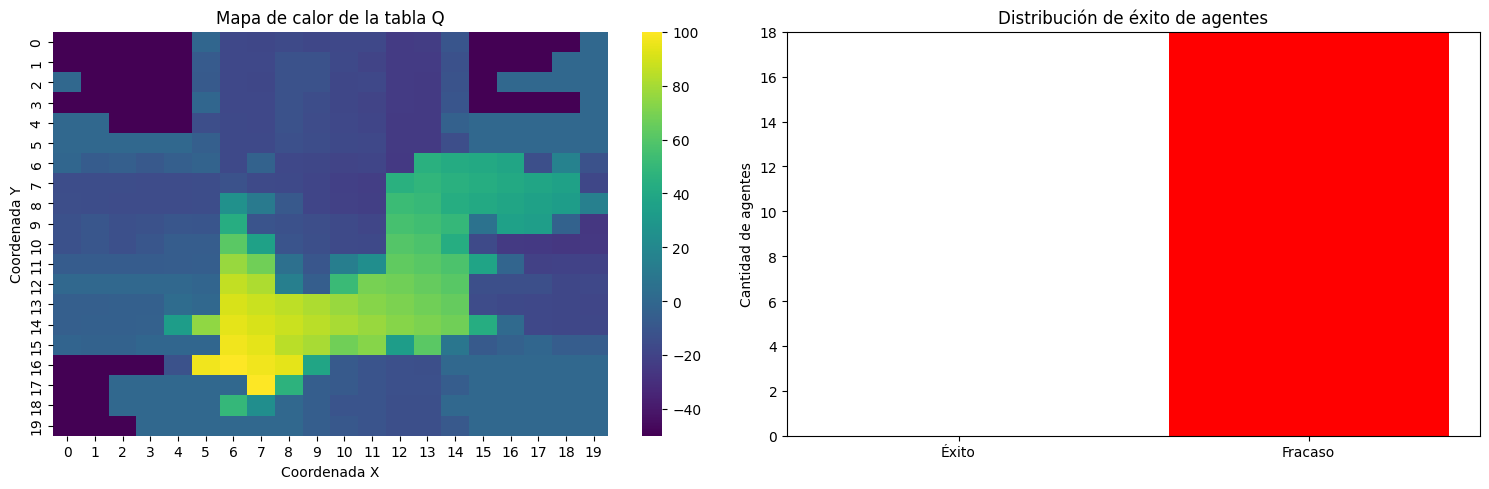

In [ ]:
model.generate_metrics_plots()

# Forzar visualización de plots
plt.show()